In [1]:
import numpy as np
import torch as th

!pip install forgi
import forgi
import forgi.graph.bulge_graph as fgb
import forgi.threedee as ft
import forgi.threedee.model.coarse_grain as ftmc


import matplotlib.pyplot as plt
import networkx as nx
import os


     |████████████████████████████████| 26.8 MB 1.4 MB/s 
     |████████████████████████████████| 2.3 MB 60.1 MB/s 
  Created wheel for forgi: filename=forgi-2.1.2-cp37-cp37m-linux_x86_64.whl size=27791619 sha256=d76563ea810ae684eb03acc1bce5f7d9593e93055ca71f4896c3bb99370364a7
  Stored in directory: /root/.cache/pip/wheels/48/70/42/e333b0de9960f1b0cea75cf70a2db08290bcc713288a607e1a
Successfully built forgi


In [2]:
print(th.__version__)
print(th.cuda.is_available())

!tar -xf data.tar.xz

1.10.0+cu111
True


In [3]:
#install PyG in google colab

!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu111.html

Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 7.9 MB 2.6 MB/s 
     |████████████████████████████████| 3.5 MB 61.7 MB/s 
     |████████████████████████████████| 2.3 MB 59.9 MB/s 
     |████████████████████████████████| 747 kB 57.0 MB/s 
     |████████████████████████████████| 370 kB 5.0 MB/s 
     |████████████████████████████████| 482 kB 69.7 MB/s 
     |████████████████████████████████| 41 kB 865 kB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.3-py3-none-any.whl size=581968 sha256=21b5b41025b4bf60dc5697b013e63fb7c3b64934f40e7fa139cba76b82a9c4d2
  Stored in directory: /root/.cache/pip/wheels/c3/2a/58/87ce0508964d4def1aafb92750c4f3ac77038efd1b9a89dcf5
Successfully built torch-geometric


TODO:
*  include checkpoints, that save model parameters for later testing **DONE**
*  how to avoid negative RMSD predicitons?
*  **implement gpu usage**
*  use dgl.save_graph() to store a graph, so the structure can be used for several steps?
*  use forgi.threedee.model.coarse_grain.CoarseGrainRNA.rotate() to rotate cg RNAs and see if the classification changes
*  future --> find where ernwin writes/stores output of structure for each n steps
*  finetune the model
*  make larger batch of training data for testing
*  include logger (maybe wandb?)



In [4]:
#Graph Building
from torch_geometric.data import Data

#load coarse grain file
def load_cg_file(file): 
    cg = ftmc.CoarseGrainRNA.from_bg_file(file) 
    c_dict = dict(cg.coords)
    t_dict = dict(cg.twists)
    coord_dict = {}
    twist_dict = {}
    for e in c_dict:
        a = th.from_numpy(c_dict[e][0])
        b = th.from_numpy(c_dict[e][1])
        coord_dict[e] = a, b
        if e in t_dict:
            c = th.from_numpy(t_dict[e][0])
            d = th.from_numpy(t_dict[e][1])
            twist_dict[e] = c, d
        
    # Get elements and neighbours:
    connections = {}
    for elem in cg.sorted_element_iterator():
        neighbours = cg.connections(elem)
        if elem not in connections:
            connections[elem] = cg.connections(elem)
    return coord_dict, twist_dict, connections

def build_graph(coord_dict, twist_dict, connections, label):
    #dictionary to convert type
    type_transl = {
        "h": [1, 0, 0, 0, 0, 0],
        "i": [0, 1, 0, 0, 0, 0],
        "m": [0, 0, 1, 0, 0, 0],
        "s": [0, 0, 0, 1, 0, 0],
        "f": [0, 0, 0, 0, 1, 0],
        "t": [0, 0, 0, 0, 0, 1]
    } 

    #encode nodes numerically for edge index
    num_graph = {}
    elem_count = {}
    for num, n in enumerate(sorted(connections)):
        num_graph[n] = num
        if n[0] not in elem_count:
            elem_count[n[0]] = 1
        else:
            elem_count[n[0]] += 1

    #build graph and edges
    u = []
    v = []
    for node in connections:
        for c in connections[node]:
            u.append(num_graph[node])
            v.append(num_graph[c])
    
    edge_index = th.tensor([u, v], dtype=th.long)

    x_dict = {"type": [], "coord": [], "twist": []}
    z = []
    for elem in sorted(connections):
        x_dict["type"].append(np.array(type_transl[elem[0]]))
        x_dict["coord"].append(np.concatenate(coord_dict[elem]))
        if elem in twist_dict:
            x_dict["twist"].append(np.concatenate(twist_dict[elem]))
        else:
            x_dict["twist"].append(np.zeros(6))
        

    #x = th.tensor(z)#np.array(z)) #USE A DICT INSTEAD
    graph = Data(x=x_dict, edge_index=edge_index, y=label)
    
    print("new graph")
    print(x.shape)
    print(graph.x)
    print(graph.y)
    print(graph.num_node_features)

    return graph


In [5]:
#create a dict with name and rmsd as labels
def get_rmsd_dict(rmsd_list):
    rmsd_dict = {}
    with open(rmsd_list, "r") as fh:
        for line in fh.readlines():
            name, rmsd = (line.rstrip()).split("\t")
            rmsd_dict[name] = float(rmsd)
    return rmsd_dict


In [6]:
#Graph Dataset Class
from torch_geometric.data import InMemoryDataset

class CGDataset(InMemoryDataset):
    def __init__(self, root, rmsd_list, transform=None, pre_transform=None):
        self.file_path = root
        self.rmsd_list = rmsd_list
        super(CGDataset, self).__init__(root, transform, pre_transform)

    @property
    def raw_file_names(self):
        return [f for f in os.listdir(self.file_path) if os.path.isfile(os.path.join(self.file_path, f))]
    
    @property
    def processed_file_names(self):
        return ['data.pt']

    def process(self):
        self.graphs = []
        rmsd_dict = get_rmsd_dict(self.rmsd_list)
        #self.labels = []
        
        files = []
        #filenames = next(os.walk(self.file_path), (None, None, []))[2] #use raw_file_names?

        for file in self.raw_file_names:
            if file.endswith(".cg"):
                files.append(file)
                #self.labels.append(rmsd_dict[file])

        for struc in files:
            coord_dict, twist_dict, connections = load_cg_file(os.path.join(self.file_path, struc))
            graph = build_graph(coord_dict, twist_dict, connections, rmsd_dict[struc])
            self.graphs.append(graph) #build_graph(coord_dict, twist_dict, connections))

        #self.labels = th.tensor(self.labels)
        if self.pre_filter is not None:
            self.graphs = [data for data in self.graphs if self.pre_filter(data)]

        if self.pre_transform is not None:
            self.graphs = [self.pre_transform(data) for data in self.graphs]

        data, slices = self.collate(self.graphs)
        #th.save((data, slices), self.processed_paths[0])


    """
    #still needed in pyg?
    def __getitem__(self, i):
        return self.graphs[i], self.labels[i]

    def __len__(self):
        return len(self.graphs)
    """


In [7]:
#Model

import torch.nn.functional as F
import torch_geometric.nn as tgnn

#Coarse Grain RNA Classifier Model
class CG_Classifier(th.nn.Module):
    def __init__(self, num_features):
        self.c = 0
        super(CG_Classifier, self).__init__()
        
        self.conv1 = tgnn.TAGConv(6, 200, K=2)
        self.conv2 = tgnn.TAGConv(200, 150, K=2)
        self.conv3 = tgnn.TAGConv(150, 100, K=2)
        self.conv4 = tgnn.TAGConv(100, 50, K=2)
        self.conv5 = tgnn.TAGConv(50, 25, K=2)
        
        self.sage_conv1 = tgnn.SAGEConv(25*num_features, 60)
        self.sage_conv2 = tgnn.SAGEConv(60, 50)
        self.sage_conv3 = tgnn.SAGEConv(50, 40)
        self.sage_conv4 = tgnn.SAGEConv(40, 30)
        self.sage_conv5 = tgnn.SAGEConv(30, 20)
        
        #self.readout = tgnn.avg_pool()
        
        self.classify = th.nn.Sequential(
            th.nn.Linear(20, 512),
            th.nn.ELU(),
            th.nn.Linear(512, 512),
            th.nn.ELU(),
            th.nn.Linear(512, 512),
            th.nn.ELU(),
            th.nn.Linear(512, 512),
            th.nn.ELU(),
            th.nn.Linear(512, 1)
        )
        
    def forward(self, g):
        #TODO: adapt to pyg
        nt = g.x[0]
        nc = g.x[1]
        nw = g.x[2]
        
        nt = self.conv1(g, nt)
        nt = F.elu(nt)
        nt = self.conv2(g, nt)
        nt = F.elu(nt)
        nt = self.conv3(g, nt)
        nt = F.elu(nt)
        nt = self.conv4(g, nt)
        nt = F.elu(nt)
        nt = self.conv5(g, nt)

        nc = self.conv1(g, nc)
        nc = self.conv2(g, nc)
        nc = self.conv3(g, nc)
        nc = self.conv4(g, nc)
        nc = self.conv5(g, nc)
        
        nw = self.conv1(g, nw)
        nw = self.conv2(g, nw)
        nw = self.conv3(g, nw)
        nw = self.conv4(g, nw)
        nw = self.conv5(g, nw)
        
        #combine the features
        combi = th.cat((nt, nc, nw), 1)

        
        combi = self.sage_conv1(g, combi)
        combi = self.sage_conv2(g, combi)
        combi = self.sage_conv3(g, combi)
        combi = self.sage_conv4(g, combi)
        combi = self.sage_conv5(g, combi)
        
        tcw = self.tgnn.avg_pool(g, combi)
        
        #mean in dim 0 is used to get rid of list in list tensor.. i.e. shape [x, 1] becomes [x]
        tcw_mean = tcw.mean(dim=0) #dgl.mean_nodes(g, combi)
        
        return self.classify(tcw_mean)

In [8]:
#Training Set
from torch_geometric.loader import DataLoader

training_dir = "./data/training_set"
rmsd_list = "./data/train_rmsd_list.txt"

training_dataset = CGDataset(training_dir, rmsd_list)


Processing...
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


Streaming output truncated to the last 5000 lines.
         [ 0.0000e+00,  1.5302e+01,  1.0000e+00, -3.0350e+00,  3.0278e+01,
           1.8047e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
           0.0000e+00],
         [-3.0350e+00,  3.0278e+01,  1.8047e+00, -5.4033e+00,  3.3375e+01,
           5.1141e+00],
         [ 8.8387e-01,  2.6149e-01,  3.8782e-01,  3.5969e-01,  7.9575e-01,
          -4.8725e-01]],

        [[ 1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00],
         [-5.4033e+00,  3.3375e+01,  5.1141e+00, -1.2638e+01,  4.7177e+01,
           8.7505e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00],
         [-3.0350e+00,  3.0278e+01,  1.8047e+00,  6.

Done!


In [42]:
#Validation Set
val_dir = "./data/val_set"
val_rmsd = "./data/val_rmsd_list.txt"

val_dataset = CGDataset(val_dir, val_rmsd)

val_dataloader = DataLoader(val_dataset)

In [39]:
#Training
import time
start = time.perf_counter()

device = th.device('cuda' if th.cuda.is_available() else 'cpu')
model = CG_Classifier(
    num_features=3 #len(graph.ndata)
).to(device)

b_size = 32
train_dataloader = DataLoader(training_dataset, batch_size=b_size, shuffle=True)
print(train_dataloader)
for batch in train_dataloader:
    print(batch)

opt = th.optim.Adam(model.parameters(), lr=1e-3)
model.train()

epochs = 500

#val setup
val_losses = []

#training setup
epoch_losses = []
for epoch in range(epochs):
    epoch_loss = 0
    
    for iter, batch in enumerate(train_dataloader): #next in line to be adapted to pyg
        l = []
        print(batch.num_graphs)
        for graph in dgl.unbatch(batched_graph): #is there a way to use directly the batched_graph object?
            pred = model(graph)
            l.append(pred)
        
        logits = th.cat(l)
        loss = F.smooth_l1_loss(logits, batch_labels, reduction='mean') # smooth_l1_loss

        opt.zero_grad()
        loss.backward()
        opt.step()
        epoch_loss += loss.detach().item()
    
    epoch_loss /= (iter + 1)
    epoch_losses.append(epoch_loss)

    #val setup
    val_loss = 0
    for i, (v_graph, v_label) in enumerate(val_dataloader):
        val_pred = model(v_graph)
        v_loss = F.smooth_l1_loss(val_pred, v_label, reduction='mean')  # smooth_l1_loss
        val_loss += v_loss.detach().item()

    val_loss /= (i + 1)
    
    val_losses.append(val_loss)
    
    if epoch >= 20:
        th.save(model.state_dict(), "model_data/model_epoch" + str(epoch) + ".pth")
    
    if epoch % 5 == 0:
        print("Epoch {}: Training loss {:.4f}, Validation loss {:.4f}".format(epoch, epoch_loss, val_loss))
        
end = time.perf_counter()

print("Training took {:.2f} minutes".format((end - start)/60))
print("Minimum Training Loss {:.4f} in epoch {}".format(min(epoch_losses), epoch_losses.index(min(epoch_losses))))
print("Minimum Validation Loss {:.4f} in epoch {}".format(min(val_losses), val_losses.index(min(val_losses))))

#plot the training run
plt.plot(epoch_losses)
plt.plot(val_losses, 'r')
plt.title("Training Loss")
plt.ylim(ymax=10, ymin=0)
plt.draw()

TypeError: ignored

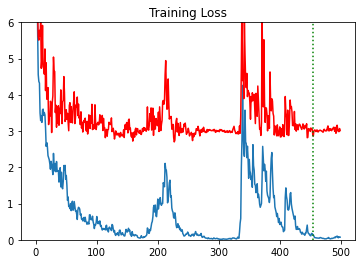

In [ ]:
#plot the training run
plt.plot(epoch_losses)
plt.plot(val_losses, 'r')
plt.title("Training Loss")
plt.ylim(ymax = 6, ymin = 0)
plt.axvline(x = 455, c = 'g', ls = ':')
plt.draw()

In [ ]:
#Test Data
test_dir = "./data/test_set"
test_rmsd = "./data/test_rmsd_list.txt"

test_dataset = CGDataset(test_dir, test_rmsd)

test_dataloader = dtl.pytorch.GraphDataLoader(test_dataset)

tensor([0.]) tensor([0.0301], grad_fn=<AddBackward0>) 0.03013432025909424
tensor([29.3100]) tensor([4.4378], grad_fn=<AddBackward0>) 24.872236251831055
Mean Test loss: 	 3.4010
Std. Dev. of Test loss:  4.2547
Min loss: 		 0.0301
First Quantile: 	 0.5217
Median: 		 2.3516
Third Quantile: 	 4.3725
Max Loss: 		 24.8722
[14.994844436645508, 15.1478271484375, 16.651601791381836, 18.817138671875, 24.872236251831055]


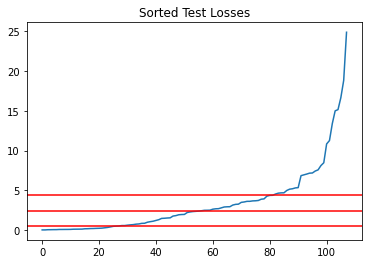

In [ ]:
#Test
import math

model.load_state_dict(th.load("model_data/model_epoch457.pth"))
model.eval()

max_label = 0
max_loss = 0
max_pred = 0
min_label = math.inf
min_loss = math.inf
min_pred = math.inf
test_losses = []
for test_graph, test_label in test_dataloader:
    test_pred = model(test_graph)
    test_loss = F.l1_loss(test_pred, test_label).item() #smooth_l1_loss
    test_losses.append(test_loss)
    if test_loss > max_loss:
        max_loss = test_loss
        max_label = test_label
        max_pred = test_pred
    if test_loss < min_loss:
        min_loss = test_loss
        min_label = test_label
        min_pred = test_pred
    if test_pred < 0:
        print(test_label, test_pred)

print(min_label, min_pred, min_loss)
print(max_label, max_pred, max_loss)
test_mean = np.mean(test_losses)
test_std = np.std(test_losses)
test_fq = np.quantile(test_losses, q = 0.25)
test_median = np.median(test_losses)
test_tq = np.quantile(test_losses, q = 0.75)
print("Mean Test loss: \t {:.4f}".format(test_mean))
print("Std. Dev. of Test loss:  {:.4f}".format(test_std))
print("Min loss: \t\t {:.4f}".format(min(test_losses)))
print("First Quantile: \t {:.4f}".format(test_fq))
print("Median: \t\t {:.4f}".format(test_median))
print("Third Quantile: \t {:.4f}".format(test_tq))
print("Max Loss: \t\t {:.4f}".format(max(test_losses)))

print(sorted(test_losses)[-5:])

plt.plot(sorted(test_losses))
plt.title("Sorted Test Losses")
plt.axhline(y = test_fq, color = 'r')
plt.axhline(y = test_median, color = 'r')
plt.axhline(y = test_tq, color = 'r')
plt.draw()

In [ ]:
#play ground for diffpool
#adapted from: https://github.com/dmlc/dgl/blob/master/examples/pytorch/diffpool/model/dgl_layers/gnn.py
import numpy as np
import dgl.nn as dglnn
import torch.nn.functional as F

test_g = training_dataset[0][0]

#Diffpool returns a new adjacency matrix
# --> difficult/cant be used with the graph structure in dgl
# --> use pytorch geometric instead of dgl (or in addition?) when trying out diffpool?

def diffpool(g, feat):
    feat_gc = dglnn.SAGEConv(6, 10, 'pool')
    pool_gc = dglnn.SAGEConv(10, 6, 'pool')

    feat = feat_gc(g, feat)
    device = feat.device

    assign_tensor = pool_gc(g, feat)  # size = (sum_N, N_a), N_a is num of nodes in pooled graph.
    assign_tensor = F.softmax(assign_tensor, dim=1)
    assign_tensor = th.split(assign_tensor, g.batch_num_nodes().tolist())
    assign_tensor = th.block_diag(*assign_tensor)  # size = (sum_N, batch_size * N_a)

    h = th.matmul(th.t(assign_tensor), feat)
    adj = g.adjacency_matrix(transpose=True, ctx=device)
    adj_new = th.sparse.mm(adj, assign_tensor)
    adj_new = th.mm(th.t(assign_tensor), adj_new)

    print("Graph\n", g)
    print("Coords\n",g.ndata["coord"])
    print("Adjacency\n",adj)
    print("Adjacency new\n",adj_new)
    print("feature\n",h)
    return adj_new, h


feat = test_g.ndata["coord"]

new, h = diffpool(test_g, feat)
#new, h = diffpool(new, h)

s2s = dglnn.Set2Set(6, 3, 3)
print("Set2Set")
print(s2s(test_g, feat))

Graph
 Graph(num_nodes=12, num_edges=24,
      ndata_schemes={'type': Scheme(shape=(6,), dtype=torch.float32), 'coord': Scheme(shape=(6,), dtype=torch.float32), 'twist': Scheme(shape=(6,), dtype=torch.float32)}
      edata_schemes={})
Coords
 tensor([[-16.2003,  25.8341,  -9.3669,  -0.8601,  41.7801,  -5.0967],
        [-37.3710,  27.7035, -16.8027, -50.1810,  23.7290, -25.6145],
        [ -0.4467,  28.9303,   4.6981,   5.9378,  43.9982,  -1.4396],
        [  0.0000,  15.3020,   1.0000, -20.7810,  27.7567, -10.5808],
        [-20.7810,  27.7567, -10.5808, -27.2883,  29.1766, -16.1930],
        [-27.2883,  29.1766, -16.1930,   2.8537,  19.2841,   4.1874],
        [  2.8537,  19.2841,   4.1874,   0.0000,  15.3020,   1.0000],
        [  0.0000,   0.0000,   1.0000,   0.0000,  15.3020,   1.0000],
        [-20.7810,  27.7567, -10.5808, -16.2003,  25.8341,  -9.3669],
        [-27.2883,  29.1766, -16.1930, -37.3710,  27.7035, -16.8027],
        [  2.8537,  19.2841,   4.1874,  -0.4467,  28.9303